# Machine Learning Layer
#### Goal: Estimate the next beta

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf as tf
from plotnine import *

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [8]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data_v2.csv', index_col=0)

In [9]:
df.sort_values('beta')

,week,policy_index,variant,mobility,temperature,wind,infections,beta,beta_t_minus_1,district
89,91,83.930000,B.1.617.2,-8.857143,2.628571,9.457143,374.704082,3.786532e-28,2.082025e-16,Stuttgart
86,88,61.780000,B.1.617.2,-14.857143,5.257143,6.900000,322.224490,1.994240e-27,1.610257e-17,Stuttgart
89,91,83.930000,B.1.617.2,-11.428571,2.071429,9.171429,49.418367,2.457712e-25,1.879839e-67,Stadt Mainz
89,91,83.930000,B.1.617.2,10.857143,1.142857,10.828571,79.081633,1.169281e-24,6.964135e-19,Tübingen
88,90,81.761429,B.1.617.2,52.142857,1.942857,15.414286,58.448980,2.567168e-24,9.234650e-30,Frankfurt (Oder)
...,...,...,...,...,...,...,...,...,...,...
80,82,58.670000,B.1.617.2,3.285714,10.728571,8.557143,16.275510,1.453003e+02,1.214266e+01,Cottbus
74,76,68.790000,B.1.617.2,0.857143,13.985714,10.871429,20.173469,1.634021e+02,2.598431e+01,Schwäbisch Hall
71,73,68.370000,B.1.617.2,5.285714,16.128571,9.014286,3.734694,1.756146e+02,1.008193e+00,"Schweinfurt, Stadt"
69,71,73.210000,B.1.617.2,-3.285714,20.385714,6.885714,4.693878,1.873504e+02,3.154386e+02,Heidelberg


## 2) Visualize Data:
#### 2.1) Average Infections (training period):

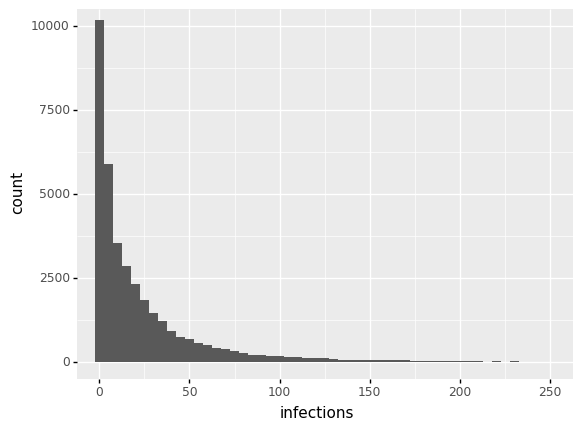

<ggplot: (343408044)>

In [10]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,250),ylim=(0,10000))

#### 2.2) Fitted beta:

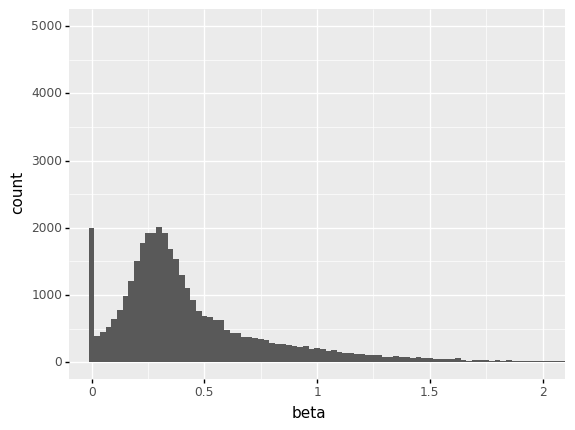

<ggplot: (317332676)>

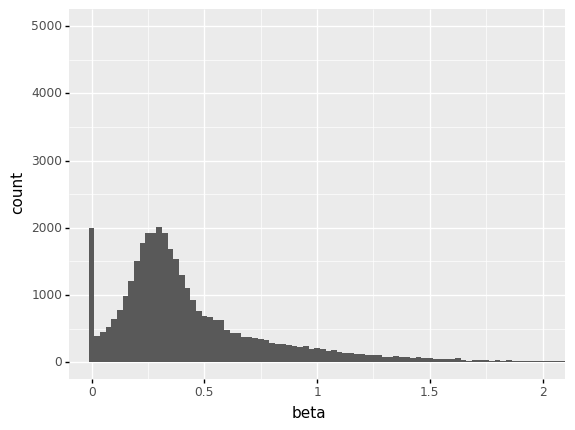

<ggplot: (344172168)>

In [11]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

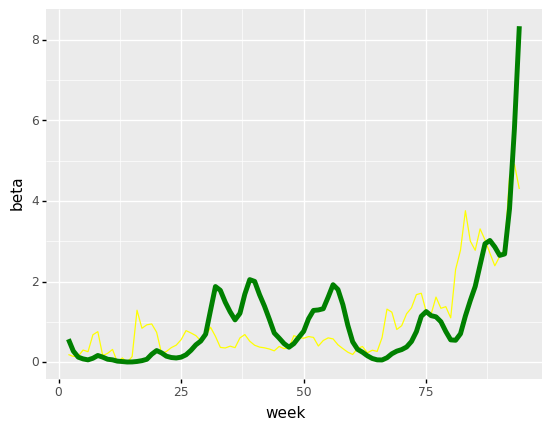

<ggplot: (343612269)>

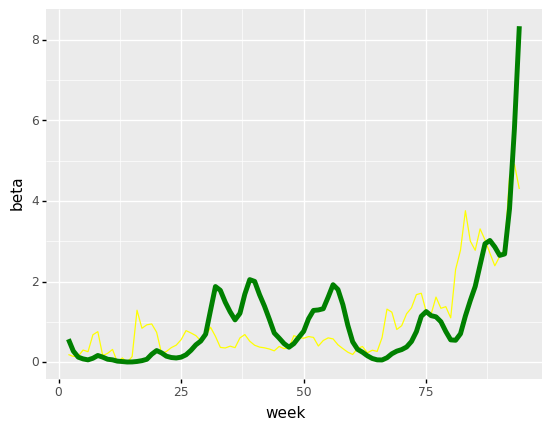

<ggplot: (343215147)>

In [12]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

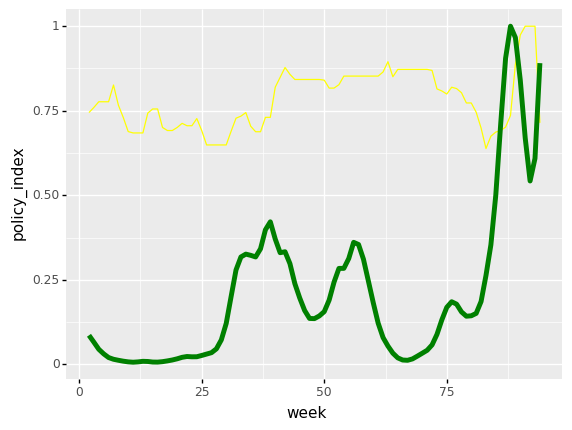

<ggplot: (343490244)>

In [13]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta: (NO LONGER NECESSARY!)

In [14]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [15]:
# Check out correlation between current and previous weeks beta:
df['beta'].corr(df['beta_t_minus_1'] )

0.639581561831509

## 4) Data cleaning:
#### Identify missing values:

In [16]:
df.isnull().sum()

week                 0
policy_index         0
variant              0
mobility             0
temperature        236
wind              3739
infections           0
beta                 0
beta_t_minus_1       0
district             0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [17]:
df_v4 = df.fillna(method='ffill').fillna(method='bfill')

## 5) Outlier removal:
#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [18]:
# Drop all rows in which average number of infections is below 5:
threshold = 5
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [19]:
# Drop all rows in which the beta value is < 0.025:
threshold = 0.025
df_v5_2 = df_v5_1[df_v5_1['beta'] > threshold]

## 6) Preprocessing columns:
#### 6.1) Handling categorical columns:

In [20]:
# Only use week and district as index columns:
df_v6_1 = df_v5_2.set_index(['week','district'])

In [21]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [22]:
# Drop "other" variant column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

In [23]:
# Drop zero column:
df_v6_2_e = df_v6_2_d.drop(columns='0', axis=1)

#### 6.2) Standardizing:

In [135]:
# Standardize:
scaler_obj = StandardScaler()

# Split explanatory columns from beta:
explanatory_cols = df_v6_2_e.drop(columns=['beta','beta_t_minus_1'], axis=1)
beta_cols = df_v6_2_e[['beta','beta_t_minus_1']]

# Apply scaling:
scaled_explanatory_cols = pd.DataFrame(scaler_obj.fit_transform(explanatory_cols), index=explanatory_cols.index, columns=explanatory_cols.columns)

# Merge both together again:
df_v6_3 = pd.concat([scaled_explanatory_cols, beta_cols], axis=1)

## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [136]:
df_modeling = df_v6_3
df_modeling

,,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta,beta_t_minus_1
week,district,,,,,,,,,
2,Aachen,-0.698986,-0.720248,-0.614720,-2.563934,-0.432627,-0.111012,0.089014,0.279309,0.323253
3,Aachen,-0.698986,-0.720248,-0.438390,-2.077971,-0.306793,-0.111012,-0.099748,0.144432,0.378669
4,Aachen,-0.698986,-0.720248,-0.245118,-1.734939,1.244361,-0.261843,-0.240578,0.198363,0.151111
5,Aachen,-0.698986,-0.720248,-0.245118,-1.973156,0.569210,-0.133085,-0.344224,0.180248,0.177820
6,Aachen,-0.698986,-0.720248,-0.245118,-1.363320,0.978173,1.434083,-0.448241,0.062893,0.251340
...,...,...,...,...,...,...,...,...,...,...
90,Zwickau,-0.698986,1.388410,2.041648,-0.429510,-1.010982,1.412010,4.438816,0.614033,0.548931
91,Zwickau,-0.698986,1.388410,2.340718,0.046924,-1.236033,-0.787911,3.151207,0.513378,0.609274
92,Zwickau,-0.698986,1.388410,2.340718,0.151740,-0.488285,-0.283916,1.891271,0.415119,0.568880


#### 7.1.2) Split into train val:

In [137]:
SEED = 420

In [138]:
X_full = df_modeling.drop(columns=['beta'], axis=1)
y_full = df_modeling['beta']

In [139]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, shuffle=True, train_size=0.75, random_state=SEED)

### 7.2 Models
#### 7.2.1) Baseline Approach: Choosing previous beta

In [140]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:
y_pred_baseline = X_val['beta_t_minus_1']

In [141]:
# Correlation of this approach:
X_full['beta_t_minus_1'].corr(y_full)

0.7459144438106486

In [142]:
pd.DataFrame({'y_val':y_val, 'y_pred_baseline':y_pred_baseline})

,,y_val,y_pred_baseline
week,district,,
89,Eichstätt,0.768745,0.787189
38,Hamburg,0.390489,0.395175
76,Rheingau-Taunus,0.819332,1.138713
77,Landkreis Rostock,0.513399,1.210469
2,Olpe,0.296292,1.313517
...,...,...,...
48,Vorpommern-Greifswald,0.272258,0.282582
37,Vorpommern-Rügen,0.649366,0.095626
44,Vechta,0.230530,0.293331


In [143]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 2.2186799227537306


#### 7.2.2) Multivariate Linear Regression

In [144]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [145]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 2.124645755847725. This is an improvement compared to the baseline approach of: 4.2382934979325215 %


#### 7.2.3) Ridge Regression:

In [146]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train, y_train)

y_pred_ridge_reg = ridge_reg.predict(X_val)
rmse_ridge_reg = mean_squared_error(y_val, y_pred_ridge_reg, squared=False)

In [147]:
print(f'RMSE of {ridge_reg} is: {rmse_ridge_reg}. This is an improvement compared to the baseline approach of: {-(rmse_ridge_reg / rmse_baseline -1)*100} %')

RMSE of Ridge() is: 2.1246522752150674. This is an improvement compared to the baseline approach of: 4.23799965801106 %


#### 7.2.4) Random Forest Regressor:

In [148]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [149]:
print(f'RMSE of {rfg_model} is: {rmse_random_forest}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 2.328354400311656. This is an improvement compared to the baseline approach of: -4.9432311724262545 %


#### 7.2.5) Support Vector Machines

In [150]:
svm = SVR()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)
rmse_svm = mean_squared_error(y_val, y_pred_svm, squared=False)

In [151]:
print(f'RMSE of {svm} is: {rmse_svm}. This is an improvement compared to the baseline approach of: {-(rmse_svm / rmse_baseline -1)*100} %')

RMSE of SVR() is: 3.0253722360438458. This is an improvement compared to the baseline approach of: -36.35911178611484 %


#### 7.2.6) XGBoost

In [152]:
xgb_model = xgb.XGBRegressor(verbosity=0)
xgb_model.name = 'XGBoostRegressor'
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)

In [153]:
print(f'\n RMSE of {xgb_model.name} is: {rmse_xgb}. This is an improvement compared to the baseline approach of: {-(rmse_xgb / rmse_baseline -1)*100} %')


 RMSE of XGBoostRegressor is: 1.8575278894533103. This is an improvement compared to the baseline approach of: 16.277788859790732 %


In [154]:
pd.DataFrame({'beta_opt':y_val, 'last_beta':y_pred_baseline, 'xgb_bred':y_pred_xgb})

,,beta_opt,last_beta,xgb_bred
week,district,,,
89,Eichstätt,0.768745,0.787189,0.773029
38,Hamburg,0.390489,0.395175,0.350161
76,Rheingau-Taunus,0.819332,1.138713,0.824946
77,Landkreis Rostock,0.513399,1.210469,0.744850
2,Olpe,0.296292,1.313517,0.521151
...,...,...,...,...
48,Vorpommern-Greifswald,0.272258,0.282582,0.329464
37,Vorpommern-Rügen,0.649366,0.095626,0.419802
44,Vechta,0.230530,0.293331,0.250956


#### 7.2.7) Neural Network

In [87]:
ann_model = Sequential([
    Dense(24, input_dim=len(X_train.columns), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# compile model:
ann_model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics=[RootMeanSquaredError(name='rmse')]
)

In [88]:
history = ann_model.fit(X_train,
                        y_train,
                        epochs=20,
                        # class_weight=class_weight,
                        validation_data=(X_val, y_val),
                        )

Epoch 1/20
541/541 [==============================] - 2s 2ms/step - loss: 5.3822 - rmse: 2.3200 - val_loss: 5.0819 - val_rmse: 2.2543
Epoch 2/20
541/541 [==============================] - 1s 1ms/step - loss: 4.2350 - rmse: 2.0579 - val_loss: 4.3782 - val_rmse: 2.0924
Epoch 3/20
541/541 [==============================] - 1s 2ms/step - loss: 3.8644 - rmse: 1.9658 - val_loss: 4.4452 - val_rmse: 2.1084
Epoch 4/20
541/541 [==============================] - 1s 3ms/step - loss: 4.4760 - rmse: 2.1157 - val_loss: 4.9810 - val_rmse: 2.2318
Epoch 5/20
541/541 [==============================] - 1s 3ms/step - loss: 3.8058 - rmse: 1.9509 - val_loss: 4.5857 - val_rmse: 2.1414
Epoch 6/20
541/541 [==============================] - 1s 2ms/step - loss: 4.0906 - rmse: 2.0225 - val_loss: 4.7136 - val_rmse: 2.1711
Epoch 7/20
541/541 [==============================] - 1s 2ms/step - loss: 4.0384 - rmse: 2.0096 - val_loss: 4.4705 - val_rmse: 2.1143
Epoch 8/20
541/541 [==============================] - 1s 2ms/s

In [107]:
y_pred_ann = ann_model.predict(X_val)
rmse_ann = mean_squared_error(y_val, y_pred_ann, squared=False)

In [108]:
print(f'RMSE of {ann_model} is: {rmse_ann}. This is an improvement compared to the baseline approach of: {-(rmse_ann / rmse_baseline -1)*100} %')

RMSE of <keras.engine.sequential.Sequential object at 0x1749228e0> is: 2.2050679851556505. This is an improvement compared to the baseline approach of: 0.6135151563991914 %
